In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%cd drive/MyDrive/StyleEX/

[Errno 2] No such file or directory: 'drive/MyDrive/StyleEX/'
/content/drive/MyDrive/StyleEX


In [23]:
%ls data/stylegan2/Dogs-Cats/

train/


In [24]:
%pip install labml
%pip install labml_helpers
%pip install labml_nn
%pip install lpips
%pip install tfrecord

In [25]:
#@title Architecture Utils
import math
from typing import Tuple, Optional, List

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn


class MappingNetwork(nn.Module):
    """
    <a id="mapping_network"></a>
    ## Mapping Network
    ![Mapping Network](mapping_network.svg)
    This is an MLP with 8 linear layers.
    The mapping network maps the latent vector $z \in \mathcal{W}$
    to an intermediate latent space $w \in \mathcal{W}$.
    $\mathcal{W}$ space will be disentangled from the image space
    where the factors of variation become more linear.
    """

    def __init__(self, features: int, n_layers: int, outputs: int = 0):
        """
        * `features` is the number of features in $z$ and $w$
        * `n_layers` is the number of layers in the mapping network.
        """
        super().__init__()

        if outputs == 0:
          outputs = features

        # Create the MLP
        layers = []
        for i in range(n_layers-1):
            # [Equalized learning-rate linear layers](#equalized_linear)
            layers.append(EqualizedLinear(features, features))
            # Leaky Relu
            layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        # Change sizes in last layer
        layers.append(EqualizedLinear(features, outputs))
        layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        self.net = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor):
        # Normalize $z$
        z = F.normalize(z, dim=1)
        # Map $z$ to $w$
        return self.net(z)


class Generator(nn.Module):
    """
    <a id="generator"></a>
    ## StyleGAN2 Generator
    ![Generator](style_gan2.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is a single channel).
    [`toRGB`](#to_rgb) also has a style modulation which is not shown in the diagram to keep it simple.*---
    The generator starts with a learned constant.
    Then it has a series of blocks. The feature map resolution is doubled at each block
    Each block outputs an RGB image and they are scaled up and summed to get the final RGB image.
    """

    def __init__(self, log_resolution: int, d_latent: int, n_features: int = 32, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `d_latent` is the dimensionality of $w$
        * `n_features` number of features in the convolution layer at the highest resolution (final block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Calculate the number of features for each block
        #
        # Something like `[512, 512, 256, 128, 64, 32]`
        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 2, -1, -1)]
        # Number of generator blocks
        self.n_blocks = len(features)

        # Trainable $4 \times 4$ constant
        self.initial_constant = nn.Parameter(torch.randn((1, features[0], 4, 4)))

        # First style block for $4 \times 4$ resolution and layer to get RGB
        self.style_block = StyleBlock(d_latent, features[0], features[0])
        self.to_rgb = ToRGB(d_latent, features[0])

        # Generator blocks
        blocks = [GeneratorBlock(d_latent, features[i - 1], features[i]) for i in range(1, self.n_blocks)]
        self.blocks = nn.ModuleList(blocks)

        # $2 \times$ up sampling layer. The feature space is up sampled
        # at each block
        self.up_sample = UpSample()

    def forward(self, w: torch.Tensor, input_noise: List[Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]]):
        """
        * `w` is $w$. In order to mix-styles (use different $w$ for different layers), we provide a separate
        $w$ for each [generator block](#generator_block). It has shape `[n_blocks, batch_size, d_latent]`.
        * `input_noise` is the noise for each block.
        It's a list of pairs of noise sensors because each block (except the initial) has two noise inputs
        after each convolution layer (see the diagram).
        """

        # Get batch size
        batch_size = w.shape[1]

        # Expand the learned constant to match batch size
        x = self.initial_constant.expand(batch_size, -1, -1, -1)

        # The first style block
        x = self.style_block(x, w[0], input_noise[0][0])
        # Get first rgb image
        rgb = self.to_rgb(x, w[0])

        # Evaluate rest of the blocks
        for i in range(1, self.n_blocks):
            # Up sample the feature map
            x = self.up_sample(x)
            # Run it through the [generator block](#generator_block)
            x, rgb_new = self.blocks[i - 1](x, w[i], input_noise[i])
            # Up sample the RGB image and add to the rgb from the block
            rgb = self.up_sample(rgb) + rgb_new

        # Return the final RGB image
        return rgb

    def synthesis(self, w: torch.Tensor, s: torch.Tensor, input_noise: List[Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]], s_rgb: torch.Tensor = None,):
        """
        * `w` is $w$. In order to mix-styles (use different $w$ for different layers), we provide a separate
        $w$ for each [generator block](#generator_block). It has shape `[n_blocks, batch_size, d_latent]`.
        * `input_noise` is the noise for each block.
        It's a list of pairs of noise sensors because each block (except the initial) has two noise inputs
        after each convolution layer (see the diagram).
        """

        # Get batch size
        batch_size = w.shape[1]

        # Expand the learned constant to match batch size
        x = self.initial_constant.expand(batch_size, -1, -1, -1)

        # The first style block
        x = self.style_block.synthesis(x, s[0].unsqueeze(0), input_noise[0][1])
        # Get first rgb image
        if s_rgb != None:
          rgb = self.to_rgb.synthesis(x, s_rgb[0])
        else:
          rgb = self.to_rgb(x, w[0])

        # Evaluate rest of the blocks
        for i in range(1, self.n_blocks):
            # Up sample the feature map
            x = self.up_sample(x)
            # Run it through the [generator block](#generator_block)
            x, rgb_new = self.blocks[i - 1].given_styles(x, [s[2*i-1],s[2*i]], input_noise[i], s_rgb = s_rgb[i])
            # Up sample the RGB image and add to the rgb from the block
            rgb = self.up_sample(rgb) + rgb_new

        # Return the final RGB image
        return rgb
  def __noise__(self, batch_size: int, zeros:bool = False):
    noise = []
    resolution = 4
    if zeros:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.zeros(batch_size, 1, resolution, resolution)
        n2 = torch.zeros(batch_size, 1, resolution, resolution)
        noise.append((n1, n2))
        resolution *= 2
    else:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.randn(batch_size, 1, resolution, resolution)
        n2 = torch.randn(batch_size, 1, resolution, resolution)
        noise.append((n1, n2))
        resolution *= 2
    return noise

    def image_given_dlatent(self, w: torch.Tensor, s: torch.Tensor, input_noise: List[Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]], s_rgb: torch.Tensor = None,):
        return self.synthesis(w, s, input_noise, s_rgb)

    def style_vector_calculator(self, w: torch.Tensor):
        """
        * `w` is $w$. In order to mix-styles (use different $w$ for different layers), we provide a separate
        $w$ for each [generator block](#generator_block). It has shape `[n_blocks, batch_size, d_latent]`.
        * `input_noise` is the noise for each block.
        It's a list of pairs of noise sensors because each block (except the initial) has two noise inputs
        after each convolution layer (see the diagram).
        """

        # Get batch size
        batch_size = w.shape[1]

        style_vector_block = []
        style_vector_torgb = []
      
        # The first style block
        s = self.style_block.get_styles(w[0])
        style_vector_block.append(s)

        # Get first rgb image
        rgb = self.to_rgb.get_styles(w[0])
        style_vector_torgb.append(rgb)

        # Evaluate rest of the blocks
        for i in range(1, self.n_blocks):
            # Run it through the [generator block](#generator_block)
            s, rgb = self.blocks[i - 1].get_styles_from_block(w[i])
            style_vector_block += s
            style_vector_torgb += rgb

        # Return the final RGB image
        return style_vector_torgb, style_vector_block

class GeneratorBlock(nn.Module):
    """
    <a id="generator_block"></a>
    ### Generator Block
    ![Generator block](generator_block.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is a single channel).
    [`toRGB`](#to_rgb) also has a style modulation which is not shown in the diagram to keep it simple.*---
    The generator block consists of two [style blocks](#style_block) ($3 \times 3$ convolutions with style modulation)
    and an RGB output.
    """

    def __init__(self, d_latent: int, in_features: int, out_features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        """
        super().__init__()

        # First [style block](#style_block) changes the feature map size to `out_features`
        self.style_block1 = StyleBlock(d_latent, in_features, out_features)
        # Second [style block](#style_block)
        self.style_block2 = StyleBlock(d_latent, out_features, out_features)
        self.s1_length = in_features
        self.s2_length = out_features
        # *toRGB* layer
        self.to_rgb = ToRGB(d_latent, out_features)

    def forward(self, x: torch.Tensor, w: torch.Tensor, noise: Tuple[Optional[torch.Tensor], Optional[torch.Tensor]]):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tuple of two noise tensors of shape `[batch_size, 1, height, width]`
        """
        # First style block with first noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        x = self.style_block1(x, w, noise[0])
        # Second style block with second noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        x = self.style_block2(x, w, noise[1])

        # Get RGB image
        rgb = self.to_rgb(x, w)

        # Return feature map and rgb image
        return x, rgb
    
    def given_styles(self, x: torch.Tensor, s: torch.Tensor, noise: Tuple[Optional[torch.Tensor], Optional[torch.Tensor]], s_rgb: torch.Tensor = None):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tuple of two noise tensors of shape `[batch_size, 1, height, width]`
        """
        # First style block with first noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        if len(s[0].shape) == 1:
          s[0].unsqueeze_(0)
        if len(s[1].shape) == 1:
          s[1].unsqueeze_(0)
        x = self.style_block1.synthesis(x, s[0], noise[0])
        # Second style block with second noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        x = self.style_block2.synthesis(x, s[1], noise[1])

        # Get RGB image
        rgb = self.to_rgb.synthesis(x, s_rgb.unsqueeze(0))

        # Return feature map and rgb image
        return x, rgb

    def get_styles_from_block(self, w: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tuple of two noise tensors of shape `[batch_size, 1, height, width]`
        """
        # First style block with first noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        s1 = self.style_block1.get_styles(w)
        # Second style block with second noise tensor.
        # The output is of shape `[batch_size, out_features, height, width]`
        s2 = self.style_block2.get_styles(w)

        # Get RGB image
        rgb = self.to_rgb.get_styles(w)

        # Return feature map and rgb image
        print(s1.shape)
        print(s2.shape)
        print()
        return [s1, s2], rgb

class StyleBlock(nn.Module):
    """
    <a id="style_block"></a>
    ### Style Block
    ![Style block](style_block.svg)
    ---*$A$ denotes a linear layer.
    $B$ denotes a broadcast and scaling operation (noise is single channel).*---
    Style block has a weight modulation convolution layer.
    """

    def __init__(self, d_latent: int, in_features: int, out_features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        """
        super().__init__()
        # Get style vector from $w$ (denoted by $A$ in the diagram) with
        # an [equalized learning-rate linear layer](#equalized_linear)
        self.to_style = EqualizedLinear(d_latent, in_features, bias=1.0)
        # Weight modulated convolution layer
        self.conv = Conv2dWeightModulate(in_features, out_features, kernel_size=3)
        # Noise scale
        self.scale_noise = nn.Parameter(torch.zeros(1))
        # Bias
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.style_length = in_features

        # Activation function
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x: torch.Tensor, w: torch.Tensor, noise: Optional[torch.Tensor]):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tensor of shape `[batch_size, 1, height, width]`
        """
        # Get style vector $s$
        s = self.to_style(w)
        # Weight modulated convolution
        x = self.conv(x, s)
        # Scale and add noise
        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])

    def synthesis(self, x: torch.Tensor, s: torch.Tensor, noise: Optional[torch.Tensor]):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tensor of shape `[batch_size, 1, height, width]`
        """
        # Weight modulated convolution
        x = self.conv(x, s)
        # Scale and add noise
        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])

    def get_styles(self, w: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        * `noise` is a tensor of shape `[batch_size, 1, height, width]`
        """
        # Get style vector $s$
        return self.to_style(w)

class ToRGB(nn.Module):
    """
    <a id="to_rgb"></a>
    ### To RGB
    ![To RGB](to_rgb.svg)
    ---*$A$ denotes a linear layer.*---
    Generates an RGB image from a feature map using $1 \times 1$ convolution.
    """

    def __init__(self, d_latent: int, features: int):
        """
        * `d_latent` is the dimensionality of $w$
        * `features` is the number of features in the feature map
        """
        super().__init__()
        # Get style vector from $w$ (denoted by $A$ in the diagram) with
        # an [equalized learning-rate linear layer](#equalized_linear)
        self.to_style = EqualizedLinear(d_latent, features, bias=1.0)

        # Weight modulated convolution layer without demodulation
        self.conv = Conv2dWeightModulate(features, 3, kernel_size=1, demodulate=False)
        # Bias
        self.bias = nn.Parameter(torch.zeros(3))
        # Activation function
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x: torch.Tensor, w: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        """
        # Get style vector $s$
        style = self.to_style(w)
        # Weight modulated convolution
        x = self.conv(x, style)
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])

    def synthesis(self, x: torch.Tensor, style: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `w` is $w$ with shape `[batch_size, d_latent]`
        """
        # Weight modulated convolution
        x = self.conv(x, style)
        # Add bias and evaluate activation function
        return self.activation(x + self.bias[None, :, None, None])

    def get_styles(self, w: torch.Tensor):
        """
        * `w` is $w$ with shape `[batch_size, d_latent]`
        """
        # Get style vector $s$       
        return self.to_style(w)


class Conv2dWeightModulate(nn.Module):
    """
    ### Convolution with Weight Modulation and Demodulation
    This layer scales the convolution weights by the style vector and demodulates by normalizing it.
    """

    def __init__(self, in_features: int, out_features: int, kernel_size: int,
                 demodulate: float = True, eps: float = 1e-8):
        """
        * `in_features` is the number of features in the input feature map
        * `out_features` is the number of features in the output feature map
        * `kernel_size` is the size of the convolution kernel
        * `demodulate` is flag whether to normalize weights by its standard deviation
        * `eps` is the $\epsilon$ for normalizing
        """
        super().__init__()
        # Number of output features
        self.out_features = out_features
        # Whether to normalize weights
        self.demodulate = demodulate
        # Padding size
        self.padding = (kernel_size - 1) // 2

        # [Weights parameter with equalized learning rate](#equalized_weight)
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        # $\epsilon$
        self.eps = eps

    def forward(self, x: torch.Tensor, s: torch.Tensor):
        """
        * `x` is the input feature map of shape `[batch_size, in_features, height, width]`
        * `s` is style based scaling tensor of shape `[batch_size, in_features]`
        """

        # Get batch size, height and width
        b, _, h, w = x.shape

        # Reshape the scales
        s = s[:, None, :, None, None]
        # Get [learning rate equalized weights](#equalized_weight)
        weights = self.weight()[None, :, :, :, :]
        # $$w`_{i,j,k} = s_i * w_{i,j,k}$$
        # where $i$ is the input channel, $j$ is the output channel, and $k$ is the kernel index.
        #
        # The result has shape `[batch_size, out_features, in_features, kernel_size, kernel_size]`
        weights = weights * s

        # Demodulate
        if self.demodulate:
            # $$\sigma_j = \sqrt{\sum_{i,k} (w'_{i, j, k})^2 + \epsilon}$$
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            # $$w''_{i,j,k} = \frac{w'_{i,j,k}}{\sqrt{\sum_{i,k} (w'_{i, j, k})^2 + \epsilon}}$$
            weights = weights * sigma_inv

        # Reshape `x`
        x = x.reshape(1, -1, h, w)

        # Reshape weights
        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.out_features, *ws)

        # Use grouped convolution to efficiently calculate the convolution with sample wise kernel.
        # i.e. we have a different kernel (weights) for each sample in the batch
        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        # Reshape `x` to `[batch_size, out_features, height, width]` and return
        return x.reshape(-1, self.out_features, h, w)

class Classifier(nn.Module):
    def __init__(self, PATH):
        super().__init__()

        self.model = load_classifier(PATH)
    def forward(self, x: torch.Tensor):
        return self.model(x)
        
class Discriminator(nn.Module):
    """
    <a id="discriminator"></a>
    ## StyleGAN 2 Discriminator
    ![Discriminator](style_gan2_disc.svg)
    Discriminator first transforms the image to a feature map of the same resolution and then
    runs it through a series of blocks with residual connections.
    The resolution is down-sampled by $2 \times$ at each block while doubling the
    number of features.
    """

    def __init__(self, log_resolution: int, n_features: int = 64, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `n_features` number of features in the convolution layer at the highest resolution (first block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Layer to convert RGB image to a feature map with `n_features` number of features.
        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.std_dev = MiniBatchStdDev()
        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, 1)

    def forward(self, x: torch.Tensor):

        x = x - 0.5
        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.std_dev(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        return self.final(x)

class Encoder(nn.Module):
    """
    <a id="discriminator"></a>
    ## StyleGAN 2 Discriminator
    ![Discriminator](style_gan2_disc.svg)
    Discriminator first transforms the image to a feature map of the same resolution and then
    runs it through a series of blocks with residual connections.
    The resolution is down-sampled by $2 \times$ at each block while doubling the
    number of features.
    """

    def __init__(self, log_resolution: int, d_latent: int, n_features: int = 64, max_features: int = 512):
        """
        * `log_resolution` is the $\log_2$ of image resolution
        * `n_features` number of features in the convolution layer at the highest resolution (first block)
        * `max_features` maximum number of features in any generator block
        """
        super().__init__()

        # Layer to convert RGB image to a feature map with `n_features` number of features.
        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.std_dev = MiniBatchStdDev()
        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, d_latent)

    def forward(self, x: torch.Tensor):
        #print(x)
        x = x - 0.5
        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.std_dev(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)

        return self.final(x)


class DiscriminatorBlock(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.residual = nn.Sequential(DownSample(),
                                      EqualizedConv2d(in_features, out_features, kernel_size=1))
        self.block = nn.Sequential(
            EqualizedConv2d(in_features, in_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
            EqualizedConv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
        )
        self.down_sample = DownSample()
        self.scale = 1 / math.sqrt(2)

    def forward(self, x):
        residual = self.residual(x)
        x = self.block(x)
        x = self.down_sample(x)
        return (x + residual) * self.scale


class MiniBatchStdDev(nn.Module):

    def __init__(self, group_size: int = 4):
        super().__init__()
        self.group_size = group_size

    def forward(self, x: torch.Tensor):
        assert x.shape[0] % self.group_size == 0
        grouped = x.view(self.group_size, -1)
        std = torch.sqrt(grouped.var(dim=0) + 1e-8)
        std = std.mean().view(1, 1, 1, 1)
        b, _, h, w = x.shape
        std = std.expand(b, -1, h, w)
        return torch.cat([x, std], dim=1)


class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Smoothing layer
        self.smooth = Smooth()

    def forward(self, x: torch.Tensor):
        x = self.smooth(x)
        return F.interpolate(x, (x.shape[2] // 2, x.shape[3] // 2), mode='bilinear', align_corners=False)


class UpSample(nn.Module):

    def __init__(self):
        super().__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.smooth = Smooth()

    def forward(self, x: torch.Tensor):
        return self.smooth(self.up_sample(x))


class Smooth(nn.Module):
    def __init__(self):
        super().__init__()
        kernel = [[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]
        kernel = torch.tensor([[kernel]], dtype=torch.float)
        kernel /= kernel.sum()
        self.kernel = nn.Parameter(kernel, requires_grad=False)
        self.pad = nn.ReplicationPad2d(1)

    def forward(self, x: torch.Tensor):
        b, c, h, w = x.shape
        x = x.view(-1, 1, h, w)
        x = self.pad(x)
        x = F.conv2d(x, self.kernel)
        return x.view(b, c, h, w)


class EqualizedLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: float = 0.):
        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)

    def forward(self, x: torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)


class EqualizedConv2d(nn.Module):
    def __init__(self, in_features: int, out_features: int,
                 kernel_size: int, padding: int = 0):
        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))

    def forward(self, x: torch.Tensor):
        return F.conv2d(x, self.weight(), bias=self.bias, padding=self.padding)


class EqualizedWeight(nn.Module):

    def __init__(self, shape: List[int]):
        super().__init__()
        self.c = 1 / math.sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))
    def forward(self):
        return self.weight * self.c


class GradientPenalty(nn.Module):
    def forward(self, x: torch.Tensor, d: torch.Tensor):
        batch_size = x.shape[0]
        gradients, *_ = torch.autograd.grad(outputs=d,
                                            inputs=x,
                                            grad_outputs=d.new_ones(d.shape),
                                            create_graph=True)
        
        gradients = gradients.reshape(batch_size, -1)
        norm = gradients.norm(2, dim=-1)
        return torch.mean(norm ** 2)


class PathLengthPenalty(nn.Module):
    def __init__(self, beta: float):
        super().__init__()
        self.beta = beta
        self.steps = nn.Parameter(torch.tensor(0.), requires_grad=False)
        self.exp_sum_a = nn.Parameter(torch.tensor(0.), requires_grad=False)

    def forward(self, w: torch.Tensor, x: torch.Tensor):
        device = x.device
        image_size = x.shape[2] * x.shape[3]
        y = torch.randn(x.shape, device=device)
        output = (x * y).sum() / math.sqrt(image_size)

        gradients, *_ = torch.autograd.grad(outputs=output,
                                            inputs=w,
                                            grad_outputs=torch.ones(output.shape, device=device),
                                            create_graph=True)
        
        norm = (gradients ** 2).sum(dim=2).mean(dim=1).sqrt()

        if self.steps > 0:
            a = self.exp_sum_a / (1 - self.beta ** self.steps)
            loss = torch.mean((norm - a) ** 2)
        else:
            loss = norm.new_tensor(0)

        mean = norm.mean().detach()
        self.exp_sum_a.mul_(self.beta).add_(mean, alpha=1 - self.beta)
        self.steps.add_(1.)
        return loss

In [48]:
#@title Display Utils 
from typing import Optional, Tuple, List
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from io import BytesIO
import IPython.display
import torch.nn as nn
import torch

import pickle

def make_animation(image: np.ndarray,
                   resolution: int,
                   figsize: Tuple[int, int] = (20, 8)):
  fig = plt.figure(1, figsize=figsize)
  _ = plt.gca()

  def transpose_image(image):
    image_reshape = image.reshape([-1, resolution, resolution, 3])
    return image_reshape.transpose([1, 0, 2, 3]).reshape([resolution, -1, 3])
  im = plt.imshow(transpose_image(image[:, :resolution, :]),
                  interpolation='none')
  def animate_func(i):
    im.set_array(transpose_image(image[:, resolution*i:resolution*(i+1), :]))
    return [im]

  animation = matplotlib.animation.FuncAnimation(
      fig, animate_func, frames=image.shape[1] // resolution, interval=600)

  plt.close(1)
  return animation


def show_image(image, fmt='png'):
  if image.dtype == np.float32:
    image = np.uint8(image * 127.5 + 127.5)
  if image.shape[0] == 3:
    image = np.transpose(image, (1, 2, 0))
  bytes_io = BytesIO()
  Image.fromarray(image).save(bytes_io, fmt)

  IPython.display.display(IPython.display.Image(data=bytes_io.getvalue()))


def filter_unstable_images(style_change_effect: np.ndarray,
                           effect_threshold: float = 0.3,
                           num_indices_threshold: int = 750) -> np.ndarray:
  """Filters out images which are affected by too many S values."""
  unstable_images = (
      torch.sum(torch.abs(style_change_effect) > effect_threshold, dim=(1, 2, 3)) >
      num_indices_threshold)
  style_change_effect[unstable_images] = 0
  return style_change_effect


# @tf.function
# def call_synthesis(generator: networks.Generator,
#                    dlatents_in: tf.Tensor,
#                    conditioning_in: Optional[tf.Tensor] = None,
#                    labels_in: Optional[tf.Tensor] = None,
#                    training: bool = False,
#                    num_layers: int = 14,
#                    dlatent_size: int = 512) -> tf.Tensor:
#   """Calls the synthesis.

#   Args:
#     dlatents_in: the intermediate latent representation of shape [batch size,
#       num_layers, dlatent_size].
#     conditioning_in: Conditioning input to the synthesis network (can be an
#       image or output from an encoder) of shape [minibatch, channels,
#       resolution, resolution]. Set to None if unused.
#     labels_in: of shape [batch_size, label_size]. Set to None if unused.
#     training: Whether this is a training call.

#   Returns:
#     The output images and optional latent vector.

#   """
#   if labels_in is not None:
#     zero_labels = tf.zeros_like(labels_in)
#     dlatents_labels = tf.tile(tf.expand_dims(zero_labels, 1), [1, num_layers, 1])
#     if dlatent_size > 0:
#       dlatents_expanded = tf.concat([dlatents_in, dlatents_labels], axis=2)
#     else:
#       dlatents_expanded = dlatents_labels
#   else:
#     if dlatent_size == 0:
#       raise ValueError('Dlatents are empty and no labels were provided.')
#     dlatents_expanded = dlatents_in
#   # Evaluate synthesis network.
#   style_vector_blocks, style_vector_torgb = generator.style_vector_calculator(
#       dlatents_expanded[:, 0], training=training)
#   if conditioning_in is not None:
#     network_inputs = (style_vector_blocks, style_vector_torgb,
#                       conditioning_in)
#   else:
#     network_inputs = (style_vector_blocks, style_vector_torgb)
#   synthesis_results = generator.g_synthesis(network_inputs, training=training)

#   # Return requested outputs.
#   return tf.maximum(tf.minimum(synthesis_results, 1), -1)


def discriminator_filter(style_change_effect: np.ndarray,
                         all_dlatents: np.ndarray,
                         generator: Generator,
                         discriminator: None, # set to None until we ask Tim
                         classifier: Classifier,
                         sindex: int,
                         style_min: float,
                         style_max: float,
                         class_index: int,
                         num_images: int = 10,
                         label_size: int = 2,
                         change_threshold: float = 0.5,
                         shift_size: float = 2,
                         effect_threshold: float = 0.2,
                         sindex_offset: int = 0) -> bool:
  """Returns false if changing the style index adds artifacts to the images.
  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    discriminator: The discriminator model.
    sindex: The style index.
    style_min: The style min value in all images.
    style_max: The style max value in all images.
    class_index: The index of the class to check.
    num_images: The number of images to do the disciminator_filter test.
    label_size: The label size.
    change_threshold: The maximal change allowed in the discriminator
      prediction.
    shift_size: The size to shift the style index.
    effect_threshold: Used for choosing images that the classification was
      changed enough.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
  """
  for style_sign_index in range(2):
    images_idx = ((style_change_effect[:, style_sign_index, sindex,
                                       class_index]) >
                  effect_threshold).nonzero()[0]

    images_idx = images_idx[:num_images]
    dlatents = all_dlatents[images_idx]

    for i in range(len(images_idx)):
      cur_dlatent = dlatents[i:i + 1]
      (discriminator_orig, 
       discriminator_change) = get_discriminator_results_given_dlatent(
           dlatent=cur_dlatent,
           generator=generator,
           discriminator=discriminator,
           classifier=classifier,
           class_index=class_index,
           sindex=sindex + sindex_offset,
           s_style_min=style_min,
           s_style_max=style_max,
           style_direction_index=style_sign_index,
           shift_size=shift_size,
           label_size=label_size)

      if np.abs(discriminator_orig - discriminator_change) > change_threshold:
        return False
  return True


def find_significant_styles_image_fraction(
    style_change_effect: np.ndarray,
    num_indices: int,
    class_index: int,
    generator: Generator,
    classifier: Classifier,
    all_dlatents: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    effect_threshold: float = 0.2,
    min_changed_images_fraction: float = 0.03,
    label_size: int = 2,
    sindex_offset: int = 0,
    discriminator: Optional[None] = None, #set to None until we ask Tim
    discriminator_threshold: float = 0.2) -> List[Tuple[int, int]]:
  """Returns indices in the style vector which affect the classifier.
  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    num_indices: Number of styles in the result.
    class_index: The index of the class to visualize.
    generator: The generator model. Either StyleGAN or GLO.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    style_min: An array with the min value for each style index.
    style_max: An array with the max value for each style index.
    effect_threshold: Minimal change of classifier output to be considered.
    min_changed_images_fraction: Minimal fraction of images which are changed.
    label_size: The label size.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
    discriminator: The discriminator model. If None, don't filter style indices.
    discriminator_threshold: Used in discriminator_filter to define the maximal
      change allowed in the discriminator prediction.
    
  """
  effect_positive = np.sum(
      style_change_effect[:, :, :, class_index] > effect_threshold, axis=0)
  effect_positive = effect_positive.flatten()
  all_sindices = []
  sindices = np.argsort(effect_positive)[::-1]
  if discriminator is not None:
    print('Using discriminator...')
  for sindex in sindices[:num_indices*2]:
    if (effect_positive[sindex] <
        min_changed_images_fraction * style_change_effect.shape[0]):
      break
    if discriminator is not None:
      s_index = sindex % style_change_effect.shape[2]
      if not discriminator_filter(
          style_change_effect,
          all_dlatents,
          generator,
          discriminator,
          classifier,
          s_index,
          style_min[s_index + sindex_offset],
          style_max[s_index + sindex_offset],
          class_index,
          label_size=label_size,
          change_threshold=discriminator_threshold,
          sindex_offset=sindex_offset):
        continue
    all_sindices.append(sindex)
    if len(all_sindices) == num_indices:
      break

  return [(x // style_change_effect.shape[2],
           (x % style_change_effect.shape[2]) + sindex_offset)
          for x in all_sindices]


def find_significant_styles(
    style_change_effect: np.ndarray,
    num_indices: int,
    class_index: int,
    discriminator: Optional[None], #set to None until we ask Tim
    generator: Generator,
    classifier: Classifier,
    all_dlatents: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    max_image_effect: float = 0.2,
    label_size: int = 2,
    discriminator_threshold: float = 0.2,
    sindex_offset: int = 0) -> List[Tuple[int, int]]:
  """Returns indices in the style vector which affect the classifier.
  Args:
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    num_indices: Number of styles in the result.
    class_index: The index of the class to visualize.
    discriminator: The discriminator model. If None, don't filter style indices.
    generator: The generator model. Either StyleGAN or GLO.
    all_dlatents: The dlatents of each image, shape of [num_images,
      dlatent_size].
    style_min: An array with the min value for each style index.
    style_max: An array with the max value for each style index.
    max_image_effect: Ignore contributions of styles if the previously found
      styles changed the probability of the image by more than this threshold.
    label_size: The label size.
    discriminator_threshold: Used in discriminator_filter to define the maximal
      change allowed in the discriminator prediction.
    sindex_offset: The offset of the style index if style_change_effect contains
      some of the layers and not all styles.
  """
  print(style_change_effect.shape)
  num_images = style_change_effect.shape[0]
  style_effect_direction = np.maximum(
      0, style_change_effect[:, :, :, class_index].reshape((num_images, -1)))

  images_effect = np.zeros(num_images)
  all_sindices = []
  discriminator_removed = []
  while len(all_sindices) < num_indices:
    next_s = np.argmax(
        np.mean(
            style_effect_direction[images_effect < max_image_effect], axis=0))
    # if discriminator is not None:
    #   sindex = next_s % style_change_effect.shape[2]
    #   if sindex == 0:
    #     break
    #   if not discriminator_filter(
    #       style_change_effect=style_change_effect,
    #       all_dlatents=all_dlatents,
    #       generator=generator,
    #       discriminator=discriminator,
    #       classifier=classifier,
    #       sindex=sindex,
    #       style_min=style_min[sindex + sindex_offset],
    #       style_max=style_max[sindex + sindex_offset],
    #       class_index=class_index,
    #       label_size=label_size,
    #       change_threshold=discriminator_threshold,
    #       sindex_offset=sindex_offset):
    #     style_effect_direction[:, next_s] = np.zeros(num_images)
    #     discriminator_removed.append(sindex)
    #     continue

    all_sindices.append(next_s)
    images_effect += style_effect_direction[:, next_s]
    style_effect_direction[:, next_s] = 0

  return [(x // style_change_effect.shape[2],
           (x % style_change_effect.shape[2]) + sindex_offset)
          for x in all_sindices]


def _float_features(values):
   """Returns a float_list from a float / double."""
   return tf.train.Feature(float_list=tf.train.FloatList(value=values))


def sindex_to_layer_idx_and_index(style_vector_block: list,
                                  
                                  sindex: int) -> Tuple[int, int]:
  
  LAYER_SHAPES = []
  for item in style_vector_block:
    LAYER_SHAPES.append([item.s1_length])
    LAYER_SHAPES.append([item.s2_length])
  
  layer_shapes_cumsum = np.concatenate([[0], np.cumsum(LAYER_SHAPES)])
  layer_idx = (layer_shapes_cumsum <= sindex).nonzero()[0][-1]

  return layer_idx, sindex - layer_shapes_cumsum[layer_idx]

# def get_classifier_results(generator: networks.Generator,
#                            classifier: MobileNetV1,
#                            expanded_dlatent: tf.Tensor,
#                            use_softmax: bool = False):
#   image = call_synthesis(generator, expanded_dlatent)
#   # image = tf.transpose(image, (0, 2, 3, 1))
#   # results = classifier(image, training=False)
#   results = classifier(image)
#   if use_softmax:
#     return nn.Softmax(dim=1)(results).detach().numpy()[0]
#   else:
#     return results.numpy()[0]

def draw_on_image(image: np.ndarray, number: float,
                  font_file: str,
                  font_fill: Tuple[int, int, int] = (0, 0, 0)) -> np.ndarray:
  """Draws a number on the top left corner of the image."""
  fnt = ImageFont.truetype(font_file, 20)
  out_image = Image.fromarray((image * 127.5 + 127.5).astype(np.uint8))
  draw = ImageDraw.Draw(out_image)
  draw.rectangle(tuple([0, 0, 70, 20]),fill=tuple([255, 255, 255]))
  draw.multiline_text((10, 10), ('%.3f' % number), font=fnt, fill=font_fill)
  return np.array(out_image)


def generate_change_image_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    classifier: Optional[Classifier],
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    shift_size: float,
    label_size: int = 2,
    num_layers: int = 14,
    model = None 
) -> Tuple[np.ndarray, float, float]:
  """Modifies an image given the dlatent on a specific S-index.
  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.
  Returns:
    The image after the style index modification, and the output of
    the classifier on this image.
  """
  # dlatent = torch.from_numpy(dlatent)
  expanded_dlatent_tmp = torch.tile(dlatent.unsqueeze(1),[1, num_layers, 1])
  network_inputs = generator.style_vector_calculator(expanded_dlatent_tmp)
  # images_out = generator.synthesis.image_given_dlatent(expanded_dlatent_tmp, network_inputs[0])
  # images_out = torch.maximum(torch.minimum(images_out, torch.Tensor([1])), torch.Tensor([-1]))

  # network_inputs = generator.synthesis.style_vector_calculator(expanded_dlatent_tmp)
  noise = model.get_noise(1)
  s, s_rgb = generator.style_vector_calculator(expanded_dlatent_tmp.to(model.device))
  style_vector = torch.cat(s, dim=1).numpy()
  orig_value = style_vector[0, sindex]
  target_value = (s_style_min if style_direction_index == 0 else s_style_max)

  if target_value == orig_value:
    weight_shift = shift_size
  else:
    weight_shift = shift_size * (target_value - orig_value)

  layer_idx, in_idx = sindex_to_layer_idx_and_index(network_inputs[1], sindex)
  
  layer_one_hot = torch.nn.functional.one_hot(torch.Tensor([in_idx]).to(int), network_inputs[1][layer_idx].shape[1])
  
  network_inputs[1][layer_idx] += (weight_shift * layer_one_hot)
  svbg_new = group_new_style_vec_block(network_inputs[1])
  
  images_out = generator.synthesis(expanded_dlatent_tmp, noise,svbg_new)
  images_out = torch.maximum(torch.minimum(images_out, torch.Tensor([1])), torch.Tensor([-1])) 
  
  change_image = torch.tensor(images_out.numpy())
  result = classifier(change_image)
  change_prob = nn.Softmax(dim=1)(result).detach().numpy()[0, class_index] 
  change_image = change_image.permute(0, 2, 3, 1)

  return change_image, change_prob


def get_discriminator_results_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    discriminator: None, #set to None until we ask Tim
    classifier: Classifier,
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    shift_size: float = 2,
    label_size: int = 2,
) -> Tuple[float, float]:
  """Modifies an image given the dlatent on a specific S-index.
  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.
  Returns:
    The discriminator before and after.
  """
  network_inputs = generator.style_vector_calculator(dlatent)
  images_out = generator.g_synthesis(network_inputs, training=False)
  images_out = torch.maximum(torch.minimum(images_out, torch.Tensor([1])), torch.Tensor([-1]))
  labels = tf.constant(dlatent[:, -label_size:], dtype=tf.float32)
  discriminator_before = discriminator([images_out, labels], training=False)
  # I am not using the classifier output here, because it is only one.
  change_image, _ = (
      generate_change_image_given_dlatent(dlatent, generator, classifier,
                                          class_index, sindex,
                                          s_style_min, s_style_max,
                                          style_direction_index, shift_size,
                                          label_size))
  
  results = classifier(change_image)
  labels = nn.Softmax(dim=1)(results)
  change_image_for_disc = tf.transpose(change_image, (0, 3, 1, 2))
  discriminator_after = discriminator([change_image_for_disc, labels], 
                                      training=False)
  return (discriminator_before, discriminator_after)


def generate_images_given_dlatent(
    dlatent: np.ndarray,
    generator: Generator,
    classifier: Optional[Classifier],
    class_index: int,
    sindex: int,
    s_style_min: float,
    s_style_max: float,
    style_direction_index: int,
    font_file: Optional[str],
    shift_size: float = 2,
    label_size: int = 2,
    draw_results_on_image: bool = True,
    resolution: int = 256,
    num_layers: int = 14,
) -> Tuple[np.ndarray, float, float, float, float]:
  """Modifies an image given the dlatent on a specific S-index.
  Args:
    dlatent: The image dlatent, with sape [dlatent_size].
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    class_index: The index of the class to visualize.
    sindex: The specific style index to visualize.
    s_style_min: The minimal value of the style index.
    s_style_max: The maximal value of the style index.
    style_direction_index: If 0 move s to it's min value otherwise to it's max
      value.
    font_file: A path to the font file for writing the probability on the image.
    shift_size: Factor of the shift of the style vector.
    label_size: The size of the label.
    draw_results_on_image: Whether to draw the classifier outputs on the images.
  Returns:
    The image before and after the style index modification, and the outputs of
    the classifier before and after the
    modification.
  """
  # dlatent = torch.from_numpy(dlatent)
  expanded_dlatent_tmp = torch.tile(dlatent.unsqueeze(1),[1, num_layers, 1])
  svbg, _, _ = generator.style_vector_calculator(expanded_dlatent_tmp)
  result_image = np.zeros((resolution, 2 * resolution, 3), np.uint8)
  images_out = generator.image_given_dlatent(expanded_dlatent_tmp, svbg)
  images_out = torch.maximum(torch.minimum(images_out, torch.Tensor([1])), torch.Tensor([-1]))

  # no need to permute for pytorch
  # base_image = tf.transpose(images_out, [0, 2, 3, 1])

  # base_image = torch.tensor(images_out.numpy())

  # Removed flag training=False since we are using a pytorch model 
  # result = classifier(base_image, training=False)
  result = classifier(images_out)
  base_prob = nn.Softmax(1)(result)
  base_prob = base_prob.detach().numpy()[0, class_index]

  # permute so that draw_on_image() works
  base_image = images_out.permute(0, 2, 3, 1)

  if draw_results_on_image:
    result_image[:, :resolution, :] = draw_on_image(
        base_image[0].numpy(), base_prob, font_file)
  else:
    result_image[:, :resolution, :] = (base_image[0].numpy() * 127.5 +
                                       127.5).astype(np.uint8)

  change_image, change_prob = (
      generate_change_image_given_dlatent(dlatent, generator, classifier,
                                          class_index, sindex,
                                          s_style_min, s_style_max,
                                          style_direction_index, shift_size,
                                          label_size))
  if draw_results_on_image:
    result_image[:, resolution:, :] = draw_on_image(
        change_image[0].numpy(), change_prob, font_file)
  else:
    result_image[:, resolution:, :] = (
        np.maxiumum(np.minimum(change_image[0].numpy(), 1), -1) * 127.5 +
                                               127.5).astype(np.uint8)

  return (result_image, change_prob, base_prob)



def visualize_style(generator: Generator,
                    classifier: Classifier,
                    all_dlatents: np.ndarray,
                    style_change_effect: np.ndarray,
                    style_min: np.ndarray,
                    style_max: np.ndarray,
                    sindex: int,
                    style_direction_index: int,
                    max_images: int,
                    shift_size: float,
                    font_file: str,
                    label_size: int = 2,
                    class_index: int = 0,
                    effect_threshold: float = 0.3,
                    seed: Optional[int] = None,
                    allow_both_directions_change: bool = False,
                    draw_results_on_image: bool = True) -> np.ndarray:
  """Returns an image visualizing the effect of a specific S-index.
  Args:
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    all_dlatents: An array with shape [num_images, dlatent_size].
    style_change_effect: A shape of [num_images, 2, style_size, num_classes].
      The effect of each change of style on specific direction on each image.
    style_min: The minimal value of each style, with shape [style_size].
    style_max: The maximal value of each style, with shape [style_size].
    sindex: The specific style index to visualize.
    style_direction_index: If 0 move s to its min value otherwise to its max
      value.
    max_images: Maximal number of images to visualize.
    shift_size: Factor of the shift of the style vector.
    font_file: A path to the font file for writing the probability on the image.
    label_size: The size of the label.
    class_index: The index of the class to visualize.
    effect_threshold: Choose images whose effect was at least this number.
    seed: If given, use this as a seed to the random shuffling of the images.
    allow_both_directions_change: Whether to allow both increasing and
      decreasing the classifiaction (used for age).
    draw_results_on_image: Whether to draw the classifier outputs on the images.
  """

  # Choose the dlatent indices to visualize
  if allow_both_directions_change:
    images_idx = (np.abs(style_change_effect[:, style_direction_index, sindex,
                                             class_index]) >
                  effect_threshold).nonzero()[0]
  else:
    images_idx = ((style_change_effect[:, style_direction_index, sindex,
                                       class_index]) >
                  effect_threshold).nonzero()[0]
  if images_idx.size == 0:
    return np.array([])

  if seed is not None:
    np.random.seed(seed)
  np.random.shuffle(images_idx)
  images_idx = images_idx[:min(max_images*10, len(images_idx))]
  dlatents = all_dlatents[images_idx]

  result_images = []
  for i in range(len(images_idx)):
    cur_dlatent = dlatents[i:i + 1]
    (result_image, base_prob, change_prob) = generate_images_given_dlatent(
         dlatent=cur_dlatent,
         generator=generator,
         classifier=classifier,
         class_index=class_index,
         sindex=sindex,
         s_style_min=style_min[sindex],
         s_style_max=style_max[sindex],
         style_direction_index=style_direction_index,
         font_file=font_file,
         shift_size=shift_size,
         label_size=label_size,
         draw_results_on_image=draw_results_on_image)

    if np.abs(change_prob - base_prob) < effect_threshold:
      continue
    result_images.append(result_image)
    if len(result_images) == max_images:
      break

  if len(result_images) < 3:
    # No point in returning results with very little images
    return np.array([])
  return np.concatenate(result_images[:max_images], axis=0)


def visualize_style_by_distance_in_s(
    generator: Generator,
    classifier: Classifier,
    all_dlatents: np.ndarray,
    all_style_vectors_distances: np.ndarray,
    style_min: np.ndarray,
    style_max: np.ndarray,
    sindex: int,
    style_sign_index: int,
    max_images: int,
    shift_size: float,
    font_file: str,
    label_size: int = 2,
    class_index: int = 0,
    draw_results_on_image: bool = True,
    effect_threshold: float = 0.1,
    images_idx: list = [47, 50, 93, 98, 123, 165, 210, 214]) -> np.ndarray:
  """Returns an image visualizing the effect of a specific S-index.
  Args:
    generator: The generator model. Either StyleGAN or GLO.
    classifier: The classifier to visualize.
    all_dlatents: An array with shape [num_images, dlatent_size].
    all_style_vectors_distances: A shape of [num_images, style_size, 2].
      The distance each style from the min and max values on each image.
    style_min: The minimal value of each style, with shape [style_size].
    style_max: The maximal value of each style, with shape [style_size].
    sindex: The specific style index to visualize.
    style_sign_index: If 0 move s to its min value otherwise to its max
      value.
    max_images: Maximal number of images to visualize.
    shift_size: Factor of the shift of the style vector.
    font_file: A path to the font file for writing the probability on the image.
    label_size: The size of the label.
    class_index: The index of the class to visualize.
    draw_results_on_image: Whether to draw the classifier outputs on the images.
  """

  # Choose the dlatent indices to visualize
  # images_idx = np.argsort(
  #     all_style_vectors_distances[:, sindex, style_sign_index])[::-1]
  # if images_idx.size == 0:
  #   return np.array([])

  # images_idx = images_idx[:min(max_images*10, len(images_idx))]
  # dlatents = all_dlatents[images_idx]
  dlatents = all_dlatents[images_idx]

  result_images = []
  for i in range(len(images_idx)):
    cur_dlatent = dlatents[i:i + 1]
    (result_image, change_prob, base_prob) = generate_images_given_dlatent(
         dlatent=cur_dlatent,
         generator=generator,
         classifier=classifier,
         class_index=class_index,
         sindex=sindex,
         s_style_min=style_min[sindex],
         s_style_max=style_max[sindex],
         style_direction_index=style_sign_index,
         font_file=font_file,
         shift_size=shift_size,
         label_size=label_size,
         draw_results_on_image=draw_results_on_image)
    if (change_prob - base_prob) < effect_threshold:
      continue
    result_images.append(result_image)


  # if len(result_images) < 3:
  #   # No point in returning results with very little images
  #   return np.array([])
  return np.concatenate(result_images[:max_images], axis=0)


#----------------------------------------------------------------------------
def load_torch_generator(pkl_file_path='./models/generator/generator_kwargs.pkl', pth_file='./models/generator/generator.pth'):
    print('Loading generator\'s necessary kwargs...')
    with open(pkl_file_path, 'rb') as f:
        kwargs = pickle.load(f)
    print('Creating generator model...')
    G = Generator(**kwargs).eval().requires_grad_(False)
    print('Loading generator\'s state dict...')
    G.load_state_dict(torch.load(pth_file))
    print('Done')
    return G

#----------------------------------------------------------------------------

def group_new_style_vec_block(svb):

    svbg_new = []
    group_index = 0
    temp_list = []
    for i, stl_vec in enumerate(svb):
        temp_list.append(stl_vec)
        if i % 2 == 0:
            svbg_new.append(temp_list)
            temp_list = []
            group_index += 1

    return svbg_new

#----------------------------------------------------------------------------

def show_images(images, fmt='png'):
  for i in range(images.shape[0]):
    image = np.array(images[i])
    if image.dtype == np.float32:
        image = np.uint8(image * 127.5 + 127.5)
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    bytes_io = BytesIO()
    Image.fromarray(image).save(bytes_io, fmt)
    IPython.display.display(IPython.display.Image(data=bytes_io.getvalue()))

#----------------------------------------------------------------------------
def create_images_from_dlatent(G,dlat_path='saved_dlantents.pkl',num_images=1, num_layers=14):
    
    with open(dlat_path, 'rb') as f:
        dlatents_file = pickle.load(f)
    dlatents = []
    for dlat in dlatents_file:
        dlatents.append(dlat[1])
    dlatents = torch.Tensor(np.array(dlatents))
    expanded_dlatent_tmp = torch.tile(dlatents,[1, num_layers, 1])
    
    if expanded_dlatent_tmp is not None:
        style_vector_block_grouped, _, _ = G.synthesis.style_vector_calculator(expanded_dlatent_tmp[:num_images,:,:])
        gen_output = G.image_given_dlatent(expanded_dlatent_tmp[:num_images,:,:] ,style_vector_block_grouped)
        img_out = torch.maximum(torch.minimum(gen_output, torch.Tensor([1])), torch.Tensor([-1]))
        show_images(img_out)
    
#----------------------------------------------------------------------------

In [27]:
#@title Dataset Utils
class Dataset(torch.utils.data.Dataset):
    """
    ## Dataset
    This loads the training dataset and resize it to the give image size.
    """

    def __init__(self, path: str, image_size: int):
        """
        * `path` path to the folder containing the images
        * `image_size` size of the image
        """
        super().__init__()

        # Get the paths of all `jpg` files
        self.paths = [p for p in Path(path).glob(f'**/*.jpg')]

        # Transformation
        self.transform = torchvision.transforms.Compose([
            # Resize the image
            torchvision.transforms.Resize(image_size),
            # Convert to PyTorch tensor
            torchvision.transforms.ToTensor(),
        ])

    def __len__(self):
        """Number of images"""
        return len(self.paths)

    def __getitem__(self, index):
        """Get the the `index`-th image"""
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)
def get_mnist_data(train_dir, image_size, digit=8):

  data_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
  ])

  train_files = os.listdir(train_dir)
  dataset = torchvision.datasets.MNIST(root='./data', 
                        train=True, 
                        download=True, 
                        transform=data_transform)
  idx = dataset.targets==digit
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]
  return dataset
def get_mnist_2_digit_data(train_dir, image_size, digit_0=9, digit_1=8):

  data_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
  ])
  train_files = os.listdir(train_dir)
  dataset = torchvision.datasets.MNIST(root='./data', 
                        train=True, 
                        download=True, 
                        transform=data_transform)
  idx_0 = dataset.targets==digit_0
  idx_1 = dataset.targets==digit_1
  
  data_0 = dataset.data[idx_0]
  targets_0 = torch.zeros(len(data_0))
  data_1 = dataset.data[idx_1]
  targets_1 = torch.zeros(len(data_1))
  dataset.data = torch.concat((data_0,data_1), dim = 0)
  dataset.targets = torch.concat((targets_0,targets_1), dim = 0)
  return dataset

def get_catdog_data(train_dir, image_size):

  class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
  data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
  ])
  train_files = os.listdir(train_dir)
  cat_files = [tf for tf in train_files if 'cat' in tf]
  dog_files = [tf for tf in train_files if 'dog' in tf]

  cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
  dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

  catdogs = ConcatDataset([cats, dogs])
  return catdogs

In [28]:
#@title StylEx


class StylEx(nn.Module):
  def __init__(self,
               log_resolution = 5, # log image resolution
               n_z = 32, # dimensionality of the latent encoding
               n_c = 2, # dimensionality of conditional encoding (number of classes)
               n_s = 32, # dimensionality of the latent attribute layer
               color_channels = 3, # number of input channels
               classifier_path = './classifier.pt',
               device = None,
               style_mixing_prob = .9
               ):
    super().__init__()
    self.latent_dim = self.d_latent = n_z + n_c
    self.conditional_dim = n_c

    self.generator  = Generator(log_resolution, n_z+n_c, n_features=32)
    self.encoder = Encoder(log_resolution, d_latent=n_z)
    self.discriminator = Discriminator(log_resolution, n_features=32)
    self.random_mapping = MappingNetwork(features=n_z+n_c, n_layers=8)

    self.classifier = load_classifier(classifier_path)

    self.n_gen_blocks = self.generator.n_blocks
    self.device = device
    self.style_mixing_prob = style_mixing_prob

  # Generate noise for random generation
  def __noise__(self, batch_size: int, zeros:bool = False):
    noise = []
    resolution = 4
    if zeros:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.zeros(batch_size, 1, resolution, resolution, device=self.device)
        n2 = torch.zeros(batch_size, 1, resolution, resolution, device=self.device)
        noise.append((n1, n2))
        resolution *= 2
    else:
      for i in range(self.n_gen_blocks):
        if i == 0:
          n1 = None
        else:
          n1 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
        n2 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
        noise.append((n1, n2))
        resolution *= 2
    return noise

  # Sample random styles for training
  def __get_random__(self, batch_size: int):
    # Mix styles
    if torch.rand(()).item() < self.style_mixing_prob:
      # Random cross-over point
      cross_over_point = int(torch.rand(()).item() * self.n_gen_blocks)
      # Sample $z_1$ and $z_2$
      z2 = torch.randn(batch_size, self.latent_dim).to(self.device)
      z1 = torch.randn(batch_size, self.latent_dim).to(self.device)
      # Get $w_1$ and $w_2$
      w1 = self.random_mapping(z1)
      w2 = self.random_mapping(z2)
      # Expand $w_1$ and $w_2$ for the generator blocks and concatenate
      w1 = w1[None, :, :].expand(cross_over_point, -1, -1)
      w2 = w2[None, :, :].expand(self.n_gen_blocks - cross_over_point, -1, -1)
      return torch.cat((w1, w2), dim=0)

    # Without mixing
    else:
      # Sample $z$
      z = torch.randn(batch_size, self.latent_dim).to(self.device)
      # Use the mapping network trained for random sampling
      w = self.random_mapping(z)
      # Expand $w$ for the generator blocks
      return w[None, :, :].expand(self.n_gen_blocks, -1, -1)

  # Find the latent encoding vector appended with the classification vector
  def get_latent(self, x):
    z = self.encode(x)
    if self.conditional_dim > 0:
      c = self.classifier(x)
      w = torch.concat((z, c), dim=1)
    else:
      w = z
    #print('encoding', torch.abs(w).sum().item())
    return w

  # Classify the input image
  def classify(self, x):
    return F.log_softmax(self.classifier(x), dim = 1)

  # Return latent encoding of an image
  def encode(self, x):
    return self.encoder(x)

  # Transform latent, w, vector into the StyleSpace
  def get_attribute(self, w):
    print(error)
    return self.generator.StyleBlock(w)
  
  # Returns the reconstructed image and latent vector
  def reconstruct(self, x):
    w = self.get_latent(x)

    # Reconstructed
    if self.training:
      noise = self.__noise__(x.shape[0], zeros=False)
    else:
      noise = 0
    
    w = w[None, :, :].expand(self.n_gen_blocks, -1, -1)
    x_ = self.generator(w, noise)
    
    # Reconstructed latent space
    # z_ = self.encode(x_)
    # z_ = 0
    return x_, w

  def get_w(self, batch_size: int):
        """
        ### Sample $w$
        This samples $z$ randomly and get $w$ from the mapping network.
        We also apply style mixing sometimes where we generate two latent variables
        $z_1$ and $z_2$ and get corresponding $w_1$ and $w_2$.
        Then we randomly sample a cross-over point and apply $w_1$ to
        the generator blocks before the cross-over point and
        $w_2$ to the blocks after.
        """

        # Mix styles
        if torch.rand(()).item() < self.style_mixing_prob:
            # Random cross-over point
            cross_over_point = int(torch.rand(()).item() * self.n_gen_blocks)
            # Sample $z_1$ and $z_2$
            z2 = torch.randn(batch_size, self.d_latent).to(self.device)
            z1 = torch.randn(batch_size, self.d_latent).to(self.device)
            # Get $w_1$ and $w_2$
            w1 = self.random_mapping(z1)
            w2 = self.random_mapping(z2)
            # Expand $w_1$ and $w_2$ for the generator blocks and concatenate
            w1 = w1[None, :, :].expand(cross_over_point, -1, -1)
            w2 = w2[None, :, :].expand(self.n_gen_blocks - cross_over_point, -1, -1)
            return torch.cat((w1, w2), dim=0)
        # Without mixing
        else:
            # Sample $z$ and $z$
            z = torch.randn(batch_size, self.d_latent).to(self.device)
            # Get $w$ and $w$
            w = self.random_mapping(z)
            # Expand $w$ for the generator blocks
            return w[None, :, :].expand(self.n_gen_blocks, -1, -1)

  def get_noise(self, batch_size: int):
      """
      ### Generate noise
      This generates noise for each [generator block](index.html#generator_block)
      """
      # List to store noise
      noise = []
      # Noise resolution starts from $4$
      resolution = 4

      # Generate noise for each generator block
      for i in range(self.n_gen_blocks):
          # The first block has only one $3 \times 3$ convolution
          if i == 0:
              n1 = None
          # Generate noise to add after the first convolution layer
          else:
              n1 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)
          # Generate noise to add after the second convolution layer
          n2 = torch.randn(batch_size, 1, resolution, resolution, device=self.device)

          # Add noise tensors to the list
          noise.append((n1, n2))

          # Next block has $2 \times$ resolution
          resolution *= 2

      # Return noise tensors
      return noise

  def generate_images(self, batch_size: int):
        # Get latent
        w = self.get_w(batch_size)
        # Get noise
        noise = self.get_noise(batch_size)

        images = self.generator(w, noise)

        # Return images and w
        return images, w
        

  def generate_style(self, s):
    return generator(s)


In [29]:
#@title Config
"""
---
title: StyleGAN 2 Model Training
summary: >
 An annotated PyTorch implementation of StyleGAN2 model training code.
---
# [StyleGAN 2](index.html) Model Training
This is the training code for [StyleGAN 2](index.html) model.
![Generated Images](generated_64.png)
---*These are $64 \times 64$ images generated after training for about 80K steps.*---
*Our implementation is a minimalistic StyleGAN 2 model training code.
Only single GPU training is supported to keep the implementation simple.
We managed to shrink it to keep it at less than 500 lines of code, including the training loop.*
*Without DDP (distributed data parallel) and multi-gpu training it will not be possible to train the model
for large resolutions (128+).
If you want training code with fp16 and DDP take a look at
[lucidrains/stylegan2-pytorch](https://github.com/lucidrains/stylegan2-pytorch).*
We trained this on [CelebA-HQ dataset](https://github.com/tkarras/progressive_growing_of_gans).
You can find the download instruction in this
[discussion on fast.ai](https://forums.fast.ai/t/download-celeba-hq-dataset/45873/3).
Save the images inside [`data/stylegan` folder](#dataset_path).
"""

import math
from pathlib import Path
from typing import Iterator, Tuple

import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import os
import lpips

from PIL import Image

from labml import tracker, lab, monit, experiment
from labml.configs import BaseConfigs
from labml_helpers.device import DeviceConfigs
from labml_helpers.train_valid import ModeState, hook_model_outputs
#from labml_nn.gan.stylegan import Discriminator, Generator, MappingNetwork, GradientPenalty, PathLengthPenalty
from labml_nn.gan.wasserstein import DiscriminatorLoss, GeneratorLoss
from labml_nn.utils import cycle_dataloader
from torch.utils.data import ConcatDataset

class Configs(BaseConfigs):
    """
    ## Configurations
    """

    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()

    # [StyleGAN2 Discriminator](index.html#discriminator)
    discriminator: Discriminator
    # [StyleGAN2 Generator](index.html#generator)
    generator: Generator
    # [StylEx Encoder](index.html#encoder)
    encoder: Encoder
    # [StylEx Classifier](index.html#classifier)
    classifier: Classifier

    # [StylEx Model]
    model: StylEx
    
    # [Mapping network](index.html#mapping_network)
    mapping_network: MappingNetwork

    # Discriminator and generator loss functions.
    # We use [Wasserstein loss](../wasserstein/index.html)
    discriminator_loss: DiscriminatorLoss
    generator_loss: GeneratorLoss

    # Optimizers
    generator_optimizer: torch.optim.Adam
    discriminator_optimizer: torch.optim.Adam
    mapping_network_optimizer: torch.optim.Adam
    encoder_optimizer: torch.optim.Adam

    # [Gradient Penalty Regularization Loss](index.html#gradient_penalty)
    gradient_penalty = GradientPenalty()
    # Gradient penalty coefficient $\gamma$
    gradient_penalty_coefficient: float = 10.

    # [Path length penalty](index.html#path_length_penalty)
    path_length_penalty: PathLengthPenalty

    # Data loader
    loader: Iterator

    # Batch size
    batch_size: int = 32
    # Dimensionality of $z$ and $w$
    d_latent: int = 512
    # Height/width of the image
    image_size: int = 32
    # Number of layers in the mapping network
    mapping_network_layers: int = 8
    # Generator & Discriminator learning rate
    learning_rate: float = 1e-3
    # Mapping network learning rate ($100 \times$ lower than the others)
    mapping_network_learning_rate: float = 1e-5
    # Number of steps to accumulate gradients on. Use this to increase the effective batch size.
    gradient_accumulate_steps: int = 1
    # $\beta_1$ and $\beta_2$ for Adam optimizer
    adam_betas: Tuple[float, float] = (0.0, 0.99)
    # Probability of mixing styles
    style_mixing_prob: float = 0.9
    # Number of classes
    num_classes: int = 2

    # Total number of training steps
    training_steps: int = 150_000

    # Number of blocks in the generator (calculated based on image resolution)
    n_gen_blocks: int

    # ### Lazy regularization
    # Instead of calculating the regularization losses, the paper proposes lazy regularization
    # where the regularization terms are calculated once in a while.
    # This improves the training efficiency a lot.

    # The interval at which to compute gradient penalty
    lazy_gradient_penalty_interval: int = 4
    # Path length penalty calculation interval
    lazy_path_penalty_interval: int = 32
    # Skip calculating path length penalty during the initial phase of training
    lazy_path_penalty_after: int = 0

    # How often to log generated images
    log_generated_interval: int = 500
    # How often to save model checkpoints
    save_checkpoint_interval: int = 2_000

    # Training mode state for logging activations
    mode: ModeState
    # Whether to log model layer outputs
    log_layer_outputs: bool = False
    # For Classifier Loss
    KL_loss: torch.nn = torch.nn.KLDivLoss(reduction='batchmean',log_target = True)
    # For Reconstruction Loss
    lpips_loss: torch.nn
    L1_loss: torch.nn = torch.nn.L1Loss(reduction='mean')

    # [Reconstruction, Adversarial ,Classifier, Path Loss] loss weight
    loss_weights: list = [2, 1, 1, 1] 

    dataset_path: str = str('data/stylegan2/Dogs-Cats/train/')
    classifier_path: str = str('./mnist_classifier.pt')
    load_model: bool = False
    model_path: str = './StylEx_Final.pt'

    def init(self):
        """
        ### Initialize
        """
        # Create dataset
        # dataset = get_catdog_data(self.dataset_path, self.image_size)
        dataset = get_mnist_2_digit_data('./', self.image_size)
        # dataset = get_mnist_data('./', self.image_size)
        #dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
        #                                download=True, transform=transform)
        

        # Create data loader
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, num_workers=2,
                                                 shuffle=True, drop_last=True, pin_memory=True)
        # Continuous [cyclic loader](../../utils.html#cycle_dataloader)
        self.loader = cycle_dataloader(dataloader)
        
        # $\log_2$ of image resolution
        log_resolution = int(math.log2(self.image_size))

        # Create discriminator and generator
        #self.discriminator = Discriminator(log_resolution).to(self.device)
        #self.generator = Generator(log_resolution, self.d_latent).to(self.device)
        #self.encoder = Encoder(log_resolution, self.d_latent).to(self.device)
        
        #self.classifier = Classifier(self.classifier_path).to(self.device)

        self.model = StylEx(log_resolution,
                            n_z = self.d_latent, 
                            n_s = self.d_latent,
                            n_c = self.num_classes,
                            classifier_path = self.classifier_path,
                            device = self.device
                            ).to(self.device)

        if self.load_model:
          self.model.load_state_dict(torch.load(self.model_path))
        # Get number of generator blocks for creating style and noise inputs
        self.n_gen_blocks = self.model.generator.n_blocks
        
        # Create mapping network
        #self.mapping_network = MappingNetwork(self.d_latent, self.mapping_network_layers).to(self.device)
        # Create path length penalty loss
        self.path_length_penalty = PathLengthPenalty(0.99).to(self.device)

        # Add model hooks to monitor layer outputs
        if self.log_layer_outputs:
            hook_model_outputs(self.mode, self.model.discriminator, 'discriminator')
            hook_model_outputs(self.mode, self.model.generator, 'generator')
            hook_model_outputs(self.mode, self.model.random_mapping, 'mapping_network')
            hook_model_outputs(self.mode, self.model.encoder, 'encoder')

        # Discriminator and generator losses
        self.discriminator_loss = DiscriminatorLoss().to(self.device)
        self.generator_loss = GeneratorLoss().to(self.device)

        # Create optimizers
        self.discriminator_optimizer = torch.optim.Adam(
            self.model.discriminator.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )
        self.generator_optimizer = torch.optim.Adam(
            self.model.generator.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )
        self.mapping_network_optimizer = torch.optim.Adam(
            self.model.random_mapping.parameters(),
            lr=self.mapping_network_learning_rate, betas=self.adam_betas
        )
        self.encoder_optimizer = torch.optim.Adam(
            self.model.encoder.parameters(),
            lr=self.learning_rate, betas=self.adam_betas
        )

        # Set tracker configurations
        tracker.set_image("generated", True)
        self.lpips_loss = lpips.LPIPS().to(self.device)

    def reconstruct_loss(self, x, x_, w = None):

        # Latent reconstruction loss
        if w == None:
          w = self.model.encode(x)
        w_ = self.model.encode(x_)
        L_w = self.L1_loss(w, w_)
        #print('L_z', L_w.item())

        # Feature reconstruction
        L_x = self.L1_loss(x, x_)
        #print('L_x', L_x.item())

        # Feature LPIPS loss
        L_LPIPS = self.lpips_loss(x, x_).mean()
        #print('L_LPIPS', L_LPIPS.item())

        L = .1*L_w + L_x + .1*L_LPIPS

        return L

    def classifier_loss(self, x, x_):
        L = self.KLLoss(self.model.classify(x_), self.model.classify(x))
        return L

    def generate_images(self, batch_size: int):
        """
        ### Generate images
        This generate images using the generator
        """

        
        return self.model.generate_images(batch_size)
    
    def step(self, idx: int):
        """
        ### Training Step
        """

        
        # Set to 0 for StylEx training, 1 for StyleGAN Training, and idx%2
        # for mixed training
        rand_switch = 0

        # Train the discriminator
        with monit.section('Discriminator'):
            # Reset gradients
            self.discriminator_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Update `mode`. Set whether to log activation
                with self.mode.update(is_log_activations=(idx + 1) % self.log_generated_interval == 0):
                    

                    # Discriminator classification for generated images

                    # Get real images from the data loader
                    r_img, lbl = next(self.loader)
                    real_images = r_img.to(self.device)

                    # Encode and Reconstruct image
                    if rand_switch == 1:
                      # Sample random images
                      generated_images, _ = self.model.generate_images(self.batch_size)
                      fake_output = self.model.discriminator(generated_images.detach())
                    else:
                      generated_images, _ = self.model.reconstruct(real_images)
                      fake_output = self.model.discriminator(generated_images.detach())
                    
                    # We need to calculate gradients w.r.t. real images for gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        real_images.requires_grad_()

                    # Discriminator classification for real images
                    real_output = self.model.discriminator(real_images)

                    # Get discriminator loss
                    real_loss, fake_loss = self.discriminator_loss(real_output, fake_output)
                    disc_loss = real_loss + fake_loss

                    # Add gradient penalty
                    if (idx + 1) % self.lazy_gradient_penalty_interval == 0:
                        # Calculate and log gradient penalty
                        gp = self.gradient_penalty(real_images, real_output)
                        tracker.add('loss.gp', gp)
                        # Multiply by coefficient and add gradient penalty
                        disc_loss = disc_loss + 0.5 * self.gradient_penalty_coefficient * gp * self.lazy_gradient_penalty_interval

                    # Compute gradients
                    disc_loss.backward()

                    # Log discriminator loss
                    tracker.add('loss.discriminator_real', real_loss)
                    tracker.add('loss.discriminator_fake', fake_loss)

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('discriminator', self.model.discriminator)
            
            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.discriminator.parameters(), max_norm=1.0)
            # Take optimizer step
            self.discriminator_optimizer.step()

        # Train the generator
        with monit.section('Generator'):
            # Reset gradients
            self.generator_optimizer.zero_grad()
            self.mapping_network_optimizer.zero_grad()
            self.encoder_optimizer.zero_grad()
            # self.affine_optimizer.zero_grad()

            # Accumulate gradients for `gradient_accumulate_steps`
            for i in range(self.gradient_accumulate_steps):
                # Get generator loss
                if rand_switch == 0:
                  # Reconstructed images
                  generated_images, _ = self.model.generate_images(self.batch_size)
                  generated_images = generated_images.detach()

                  recon_images, w = self.model.reconstruct(real_images)
                  gen_loss_rec = self.reconstruct_loss(real_images, 
                                                     recon_images)
                  recon_output = self.model.discriminator(recon_images)
                  gen_loss_adv = self.generator_loss(recon_output)
                  gen_loss_class = self.KL_loss(
                    self.model.classify(recon_images),
                    self.model.classify(real_images)
                    )
                  # Combine losses using config weight
                  gen_loss =  self.loss_weights[0]*gen_loss_rec + \
                              self.loss_weights[1]*gen_loss_adv + \
                              self.loss_weights[2]*gen_loss_class
                #Standard StyleGAN training
                else:
                  # Sample images from generator
                  generated_images, w = self.model.generate_images(self.batch_size)
                  # Discriminator classification for generated images
                  fake_output = self.model.discriminator(generated_images)
                  gen_loss = self.generator_loss(fake_output)
                                
                # Add path length penalty
                if idx > self.lazy_path_penalty_after and \
                  (idx + 1) % self.lazy_path_penalty_interval == 0:
                    # Calculate path length penalty
                    plp = self.path_length_penalty(w, recon_images)
                    # Ignore if `nan`
                    if not torch.isnan(plp):
                        tracker.add('loss.plp', plp)
                        gen_loss = gen_loss + self.loss_weights[3] * plp
                gen_loss = gen_loss.mean()
                # Calculate gradients
                gen_loss.backward()

                # Log generator loss
                if(rand_switch==0):
                  tracker.add('loss.classifier', gen_loss_class)
                  tracker.add('loss.reconstruction', gen_loss_rec)
                  tracker.add('loss.adversarial', gen_loss_adv)
                else:
                  tracker.add('loss.generator', gen_loss)
          

            if (idx + 1) % self.log_generated_interval == 0:
                # Log discriminator model parameters occasionally
                tracker.add('generator', self.model.generator)
                tracker.add('mapping_network', self.model.random_mapping)

            # Clip gradients for stabilization
            torch.nn.utils.clip_grad_norm_(self.model.generator.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(self.model.random_mapping.parameters(), max_norm=1.0)

            # Take optimizer step
            self.generator_optimizer.step()
            self.mapping_network_optimizer.step()
            self.encoder_optimizer.step()
            #print(generated_images.shape)
            #print(recon_images.shape)

        # Log generated images
        if (idx + 1) % self.log_generated_interval == 0:
            tracker.add('generated', torch.cat([generated_images[:3],recon_images[:3], real_images[:3]], dim=0))
        # Save model checkpoints
        if (idx + 1) % self.save_checkpoint_interval == 0:
            experiment.save_checkpoint()

        # Flush tracker
        tracker.save()


    def train(self):
        """
        ## Train model
        """

        # Loop for `training_steps`
        for i in monit.loop(self.training_steps):
            # Take a training step
            self.step(i)
            #
            if (i + 1) % self.log_generated_interval == 0:
                tracker.new_line()
            if i % 1000 == 0:
              torch.save(self.model.state_dict(), './StylEx.pt')
def load_classifier(path):
  device = 'cuda'
  model = torchvision.models.densenet121(pretrained=True)

  num_ftrs = model.classifier.in_features
  model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
    )
  model = model.to(device)
  model.load_state_dict(torch.load(path))
  return model



In [30]:
#@title Main
def main(load_model=False):
     # Create an experiment
    experiment.create(name='stylegan2')
    # Create configurations object
    configs = Configs()

    # Set configurations and override some
    experiment.configs(configs, {
        'device.cuda_device': 0,
        'image_size': 32,
        'log_generated_interval': 200,
        'load_model' : load_model  
        })

    # Initialize
    configs.init()
    # Set models for saving and loading
    experiment.add_pytorch_models(mapping_network=configs.model.random_mapping,
                                  generator=configs.model.generator,
                                  discriminator=configs.model.discriminator)
    return configs

In [31]:
config = main(load_model=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [32]:
Trained_StylEx = config.model
dataloader = config.loader
Trained_StylEx.eval()

generator = Trained_StylEx.generator
encoder = Trained_StylEx.encoder
classifier = Trained_StylEx.classifier
generator.eval()
encoder.eval()
classifier.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [33]:
#@title Global variables

num_layers = Trained_StylEx.n_gen_blocks #????
label_size = 2
resolution = 32

## Create image given a dlatent

We choose the index of one of the 250 preloaded dlatents from which we generate an image

Real


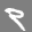

Reconstruction


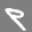

In [34]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
import IPython.display
import pickle
import requests
import collections

from tfrecord.torch.dataset import TFRecordDataset

img_index = 10

# Choose dlatent and make it into [1,num_layers,514]
imgs, lbl = next(dataloader)
imgs = imgs.to(config.device)

dlatents = Trained_StylEx.get_latent(imgs).to(config.device)
expanded_dlatent_tmp = dlatents[None, :, :].expand(Trained_StylEx.n_gen_blocks, -1, -1)

# Feed dlatent into the generator
gen_output = generator(expanded_dlatent_tmp.to(config.device), Trained_StylEx.get_noise(1)).detach()

img_out = torch.maximum(torch.minimum(gen_output, torch.Tensor([1]).to(config.device)), torch.Tensor([-1]).to(config.device)).detach()
print('Real')
show_images(imgs[img_index].unsqueeze(0).detach().to('cpu'))
print('Reconstruction')
show_images(img_out[img_index].unsqueeze(0).detach().to('cpu'))

### Generate Style space per index (min max)

In [35]:
values_per_index = collections.defaultdict(list)
for dlatent in dlatents:
    # Get the style vector:
    expanded_dlatent_tmp = dlatent.unsqueeze(0)[None, :, :].expand(Trained_StylEx.n_gen_blocks, -1, -1)
    
    s_img = torch.cat(generator.style_vector_calculator(
        expanded_dlatent_tmp)[1], dim=1).detach().to('cpu').numpy()[0]
    for i, s_val in enumerate(s_img):
        values_per_index[i].append(s_val)

values_per_index = dict(values_per_index)
s_indices_num = len(values_per_index.keys())
minimums = [min(values_per_index[i]) for i in range(s_indices_num)] 
maximums = [max(values_per_index[i]) for i in range(s_indices_num)] 
print(len(minimums))

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1

In [36]:
%mkdir ../../../../tmp/mnist
%mkdir ../../../../tmp/mnist/data

mkdir: cannot create directory ‘../../../../tmp/mnist’: File exists
mkdir: cannot create directory ‘../../../../tmp/mnist/data’: File exists


In [37]:
#@title SSpace calculation (this is also very heavy, skip to next cell to load precomputed ones) {form-width: '20%'}
import tensorflow as tf
import tqdm

def get_classifier_results(model: StylEx, latent_vec):
  noise = model.get_noise(latent_vec.shape[1])
  return model.classifier(model.generator(latent_vec, noise))

s_shift_size = .01 # @param
data_path = '../../../../tmp/mnist/data/examples_1.tfrecord' #@param {type: 'string'}
b_prob = []
c_res = []
lat = []
s_vec = []

with tf.io.TFRecordWriter(data_path) as writer:  
  dl = dlatents[0:5]
  for dlatent_index, dlatent in enumerate(dl): 
    expanded_dlatent = dlatent.unsqueeze(0)[None, :, :].expand(
        Trained_StylEx.n_gen_blocks, -1, -1)
    
    base_prob = get_classifier_results(Trained_StylEx, expanded_dlatent).detach().to('cpu')
    s_tmp = generator.style_vector_calculator(
        expanded_dlatent)
    s_rgbs = s_tmp[0]
    style_vectors = s_tmp[1]
    tot_idx = 0
    n_s = len(minimums)

    # n_styles x n_classes x n_dir 
    classifier_results = torch.zeros((n_s, 2, 2))
    s_v = torch.zeros(n_s)
    for i in range(len(style_vectors)):
      style_vector = style_vectors[i].detach()
      len_s = style_vector.shape[1]
      for sindex in tqdm.tqdm(range(0, len_s)):
        s_shift_down = (minimums[tot_idx] - style_vector[0,sindex]) * s_shift_size
        s_shift_up = (maximums[tot_idx] - style_vector[0,sindex]) * s_shift_size
        noise = Trained_StylEx.get_noise(1)

        s_v[tot_idx] = style_vector[0, sindex].item()

        # Shift up
        s = style_vector[:, sindex] + s_shift_up
        style_vectors[i] = s
        c_up = classifier(generator.synthesis(expanded_dlatent, style_vectors, noise, s_rgb = s_rgbs)).detach().to('cpu')

        # Shift down
        s = style_vector[:, sindex] - s_shift_up - s_shift_down
        style_vectors[i] = s
        c_down = classifier(generator.synthesis(expanded_dlatent, style_vectors, noise, s_rgb = s_rgbs)).detach().to('cpu')
        
        # Return to base
        s = style_vector[:, sindex] + s_shift_down
        style_vectors[i] = s

        classifier_results[tot_idx,:, 0] = c_down
        classifier_results[tot_idx,:, 1] = c_up

        tot_idx +=1

        # Get the style vector.
    s_vec.append(s_v.unsqueeze(0))
    feature = {}
    b_prob.append(base_prob.unsqueeze(0).to('cpu'))
    lat.append(dlatent.unsqueeze(0).to('cpu'))
    c_res.append(classifier_results.detach().unsqueeze(0).to('cpu'))

torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])



100%|██████████| 32/32 [00:01<00:00, 18.02it/s]


torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])



100%|██████████| 32/32 [00:01<00:00, 18.21it/s]


torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])



100%|██████████| 32/32 [00:01<00:00, 18.19it/s]


torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])



100%|██████████| 32/32 [00:01<00:00, 18.30it/s]


torch.Size([1, 256])
torch.Size([1, 128])

torch.Size([1, 128])
torch.Size([1, 64])

torch.Size([1, 64])
torch.Size([1, 32])



100%|██████████| 32/32 [00:01<00:00, 18.19it/s]


In [38]:
#@title Load effect data from the tfrecord {form-width: '20%'}

style_change_effect = []
dlatents = []
base_probs = []

base_probs = torch.cat(b_prob)
style_change_effect = torch.cat(c_res)
dlatents = torch.cat(lat)

expanded_dlatent_tmp = torch.tile(dlatents, [1, num_layers, 1])
W_values, style_change_effect, base_probs = dlatents.squeeze(), style_change_effect.squeeze(), base_probs.squeeze()
print(len(s_vec))
all_style_vectors = torch.cat(s_vec, dim = 0)
if len(style_change_effect.shape) == 3:
  style_change_effect.unsqueeze_(0)
  all_style_vectors.unsqueeze_(0)
  base_probs.unsqueeze_(0)
  W_values.unsqueeze_(0)
style_change_effect = style_change_effect.permute((0, 3, 1, 2))
print(torch.min(torch.abs(style_change_effect)))
style_change_effect = filter_unstable_images(style_change_effect, effect_threshold=10)
print(style_change_effect)
print(torch.max(torch.abs(style_change_effect)))

style_min = torch.Tensor(minimums)
style_max = torch.Tensor(maximums)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - torch.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = torch.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors
all_style_vectors.shape
stop

5
tensor(3.9458)
tensor([[[[  7.2561,  -7.0590],
          [  6.6656,  -6.9599],
          [  6.7563,  -6.9858],
          ...,
          [  9.7235, -10.5145],
          [  9.6018, -10.4121],
          [  6.6499,  -6.2509]],

         [[  7.2561,  -7.0590],
          [  6.6656,  -6.9599],
          [  6.7563,  -6.9858],
          ...,
          [  9.7235, -10.5145],
          [  9.6018, -10.4121],
          [  6.6499,  -6.2509]]],


        [[[  5.2201,  -5.1566],
          [ 12.0826, -10.6534],
          [  5.2154,  -5.1593],
          ...,
          [  8.5804,  -9.4149],
          [  8.6849,  -9.5742],
          [  9.1543,  -7.9575]],

         [[  5.2201,  -5.1566],
          [ 12.0827, -10.6534],
          [  5.2154,  -5.1593],
          ...,
          [  8.5804,  -9.4149],
          [  8.6849,  -9.5742],
          [  9.1543,  -7.9575]]],


        [[[  5.6519,  -5.3301],
          [  5.5563,  -5.2342],
          [  5.4572,  -5.1607],
          ...,
          [  7.0521,  -7.6658],


NameError: ignored

In [ ]:
W_values.shape

## Run the extraction step of AttFind

In [39]:
#@title Split by class
all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}
for img_ind in range(label_size):
  img_inx = np.array([i for i in range(all_labels.shape[0]) 
  if all_labels[i] == img_ind])
  curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], 
                                style_change_effect.shape[2], style_change_effect.shape[3]))
  curr_w = np.zeros((len(img_inx), W_values.shape[1]))
  curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
  for k, i in enumerate(img_inx):
    curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
    curr_w[k, :] = W_values[i, :].detach()
    curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
  style_effect_classes[img_ind] = curr_style_effect
  W_classes[img_ind] = curr_w
  style_vectors_distances_classes[img_ind] = curr_style_vector_distances
  all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
  print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 5 images.
Class 1, 0 images.


In [40]:
#@title Significant S values - combined {form-width: '20%'}
label_size_clasifier = 2 #@param
num_indices =  8 #@param
effect_threshold = 0.2 #@param
use_discriminator = False #@param {type: 'boolean'}
discriminator_model = None
s_indices_and_signs_dict = {}
print(style_effect_classes[1])
for class_index in [0, 1]:
  split_ind = 1 - class_index
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]

  # Find s indicies
  if all_s.shape[0]:
    s_indices_and_signs = find_significant_styles(
      style_change_effect=all_s,
      num_indices=num_indices,
      class_index=class_index,
      discriminator=discriminator_model,
      generator=generator,
      classifier=classifier,
      all_dlatents=all_w,
      style_min=style_min,
      style_max=style_max,
      max_image_effect=effect_threshold*5,
      label_size=label_size_clasifier,
      discriminator_threshold=0.2,
      sindex_offset=0)

    s_indices_and_signs_dict[class_index] = s_indices_and_signs
  else:
    s_indices_and_signs_dict[class_index] = []

# Combine the style indicies for the two classes.

sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]

all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in 
                            s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]

scores = []
for direction, sindex in all_sindex_joined_class_0:
  other_direction = 1 if direction == 0 else 0
  curr_score = torch.mean(style_change_effect[:, direction, sindex, 0]) + torch.mean(style_change_effect[:, other_direction, sindex, 1])
  scores.append(curr_score)

s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move for class 0 to 1.')

[]
(5, 2, 928, 2)
Directions and style indices for moving from class 1 to class 0 =  [(1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0)]
Use the other direction to move for class 0 to 1.


In [41]:
max_images = 8 #@param
sindex = 800 #@param
class_index = 0 #@param {type: "integer"} 
shift_sign = "1" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size =  1 #@param
effect_threshold = 0 #@param
split_by_class = False #@param {type:"boolean"}
select_images_by_s_distance = True #@param {type:"boolean"}
draw_probabilities_on_image = True #@param {type:"boolean"}

if split_by_class:
  split_ind = 1 if class_index == 0 else 0
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
  all_s_distances = style_vectors_distances_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values
  all_s_distances = all_style_vectors_distances

font_file = './arialuni.ttf'
if not os.path.exists(font_file):
  r = requests.get('https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ipwn/arialuni.ttf')
  open(font_file, 'wb').write(r.content)
stop
if not select_images_by_s_distance:
  yy = visualize_style(generator, 
                       classifier,
                       all_w,
                       all_s,
                       style_min,
                       style_max,
                       sindex,
                       wsign_index,
                       max_images=max_images,
                       shift_size=shift_size,
                       font_file=font_file,
                       label_size=label_size,
                       class_index=class_index,
                       effect_threshold=effect_threshold,
                       draw_results_on_image=draw_probabilities_on_image)
    
else:
  yy = visualize_style_by_distance_in_s(
    generator,
    classifier,
    all_w,
    all_s_distances,
    style_min,
    style_max,
    sindex,
    wsign_index,
    max_images=max_images,
    shift_size=shift_size,
    font_file=font_file,
    label_size=label_size,
    class_index=class_index,
    effect_threshold=effect_threshold,
    draw_results_on_image=draw_probabilities_on_image)

if yy.size > 0:
  show_image(yy)
else:
  print('no images found')

NameError: ignored

In [ ]:
#@title Show animation {form-width: '20%'}

import matplotlib.animation 
from IPython.display import HTML

ani = make_animation(yy, resolution)

HTML(ani.to_jshtml())

In [ ]:
#Show the 4 top attributes

index_to_naming = {1: "Skin Pigminatation", 2: "Eyebrow Thickness", 3: "Add/Remove Glasses", 4: "Dark/White Hair"}
images_list = [[5, 3], [3, 0], [0, 6], [4, 1]]
shift_sizes = shift_sizes = [(2, 1.5),(1, 1),(1, 1),(1.5, 2)]
effect_threshold = 0

print('Original images are on the first row, the probabilities displayed are for the other class - left column for being old, right column for being young)')

for i, (direction, sindex) in enumerate(s_indices_and_signs[:4]):
  images_s = np.zeros((resolution * 2, resolution * 2, 3)).astype(np.uint8)
  for d in [direction, 1 - direction]:
    class_index = 0 if d == direction else 1
    split_ind = 1 if d == direction else 0
    all_s = style_effect_classes[split_ind]
    all_s_distances = style_vectors_distances_classes[split_ind]
    
    # Generate images
    yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      all_w,
      all_s_distances,
      style_min,
      style_max,
      sindex,
      d,
      max_images=max_images,
      shift_size=shift_sizes[i][class_index],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image)
    
    for n in range(2):
      images_s[n * resolution: (n + 1) * resolution, class_index * resolution: (class_index + 1) * resolution, :] = yy[(images_list[i][class_index]) * resolution: (images_list[i][class_index] + 1) * resolution, n * resolution: (n + 1) * resolution, :]
  
  print(f'Attribute {i + 1}: {index_to_naming[i+1]}')
  show_image(images_s)

## Image-specific explanations

In this section, we implement the **Independent** selection strategy, to find the top 5 attributes for explaining a perceived-age classifier for a **specific image**


In [42]:
#Choose latent index to find image's top 5 attributes
latent_index = 0
print(base_probs.shape)

if len(base_probs.shape) == 1:
  base_probs.unsqueeze_(0)
  style_change_effect.unsqueeze(0)
  W_values[latent_index].unsqueeze(0)
  all_style_vectors.unsqueeze(0)

one_latent = torch.unsqueeze(W_values[latent_index], 0)
one_base_prob = torch.unsqueeze(base_probs[latent_index], 0)
one_style_change_effect = torch.unsqueeze(style_change_effect[latent_index], 0)

expanded_dlatent_tmp = torch.tile(one_latent, [1, num_layers, 1])

style_min,_ = torch.min(all_style_vectors, dim=0)
style_max,_ = torch.max(all_style_vectors, dim=0)
all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - torch.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = torch.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors

torch.Size([5, 2])


In [43]:
# Find s indicies
class_index = 0# @param {type: "integer"} 
label_size_clasifier = 2 #@param
num_indices = 5 #@param
effect_threshold = 0.5 #@param
use_discriminator = False #@param {type: 'boolean'}
discriminator_model = None

s_indices_and_signs = find_significant_styles(
    style_change_effect=one_style_change_effect.numpy(),
    num_indices=num_indices,
    class_index=class_index,
    discriminator=discriminator_model,
    generator=generator,
    classifier=classifier,
    all_dlatents=one_latent,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    discriminator_threshold=0.2,
    sindex_offset=0)

print(f'Directions and style indices for moving from class 1 (yound) to class {class_index} (old) = ', s_indices_and_signs[:num_indices])

(1, 2, 928, 2)
Directions and style indices for moving from class 1 (yound) to class 0 (old) =  [(1, 860), (0, 0), (0, 0), (0, 0), (0, 0)]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [49]:
shift_sign = "0" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size = 2#@param
effect_threshold = 0#@param

shift_sizes = [1, -1.5, -1, 1.5, 2.5]
index_to_naming = {1: "Add Glasses", 2: "White Hair", 3: "Neck Coverage", 4: "Receding Hairline", 5: "Glowy White Hair"}

 
for i, (direction, sindex) in enumerate(s_indices_and_signs[:5]): 
  yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      one_latent,
      all_style_vectors_distances,
      style_min,
      style_max,
      sindex,
      direction,
      max_images=max_images,
      shift_size=shift_sizes[i],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image,
      images_idx=[0])

  print(f'Attribute {i + 1}: {index_to_naming[i + 1]}')

  if yy.size > 0:
    show_image(yy)

RuntimeError: ignored